# Wymagane biblioteki

In [6]:
%pip install matplotlib numpy imageio


Note: you may need to restart the kernel to use updated packages.


# Wczytywanie obrazów za pomocą numpy

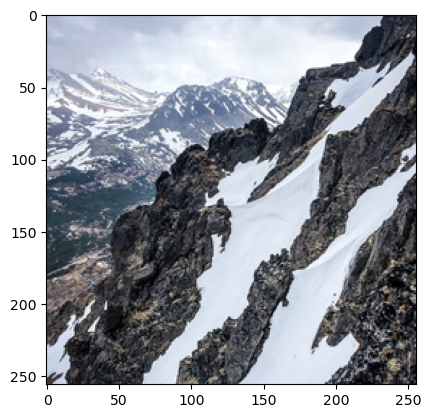

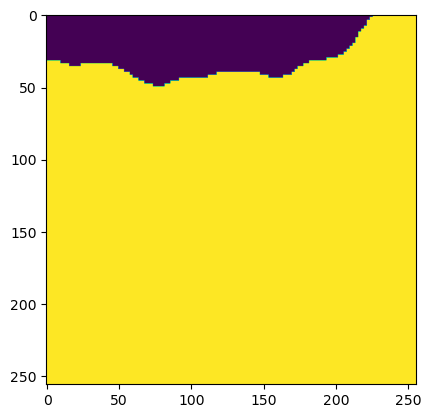

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# mmap_mode="r" nie wczytuje całego pliku do pamięci, tylko fragmenty, które są potrzebne w danym momencie

images, masks = (
    np.load("images.npy", mmap_mode="r"),
    np.load("masks.npy", mmap_mode="r"),
)

# wyświetlenie przykładowego obrazu
plt.imshow(images[0])
plt.show()

# wyświetlenie przykładowej maski
plt.imshow(masks[0])
plt.show()


# Zapisanie plików jako obrazy

In [50]:
import numpy as np
import imageio.v3 as iio

images, masks = (
    np.load("images.npy", mmap_mode="r"),
    np.load("masks.npy", mmap_mode="r"),
)

# Преобразование маски в формат RGB
mask_rgb = np.stack([masks[0]] * 3, axis=-1)  # Дублирование значений по последней оси

# Сохранение изображений и маски
iio.imwrite("example_image.png", images[0])
iio.imwrite("example_mask.png", mask_rgb)

print("Изображения успешно сохранены.")


Изображения успешно сохранены.


# Rozkład klas

### Znaczenie każdej z klas i jej wartość w pliku masks.npy

https://ade20k.csail.mit.edu/

In [51]:
class_names = [
    {"name": "Wall", "classIndex": 0, "ADE20K_classIndex": 0},
    {"name": "Sky", "classIndex": 1, "ADE20K_classIndex": 2},
    {"name": "Tree", "classIndex": 2, "ADE20K_classIndex": 4},
    {"name": "Route", "classIndex": 3, "ADE20K_classIndex": 6},
    {"name": "Grass", "classIndex": 4, "ADE20K_classIndex": 9},
    {"name": "Earth", "classIndex": 5, "ADE20K_classIndex": 13},
    {"name": "Mountain", "classIndex": 6, "ADE20K_classIndex": 16},
    {"name": "Plant", "classIndex": 7, "ADE20K_classIndex": 17},
    {"name": "Water", "classIndex": 8, "ADE20K_classIndex": 21},
    {"name": "Sea", "classIndex": 9, "ADE20K_classIndex": 26},
    {"name": "Field", "classIndex": 10, "ADE20K_classIndex": 29},
    {"name": "Rock", "classIndex": 11, "ADE20K_classIndex": 34},
    {"name": "Sand", "classIndex": 12, "ADE20K_classIndex": 46},
    {"name": "River", "classIndex": 13, "ADE20K_classIndex": 60},
    {"name": "Hill", "classIndex": 14, "ADE20K_classIndex": 68},
    {"name": "Land", "classIndex": 15, "ADE20K_classIndex": 94},
    {"name": "Waterfall", "classIndex": 16, "ADE20K_classIndex": 113},
]


### Wyświetlanie rozkładu klas

<div style="color: red">Uwaga, uruchomienie tej komórki może wymagać dużej ilości ramu!</div>

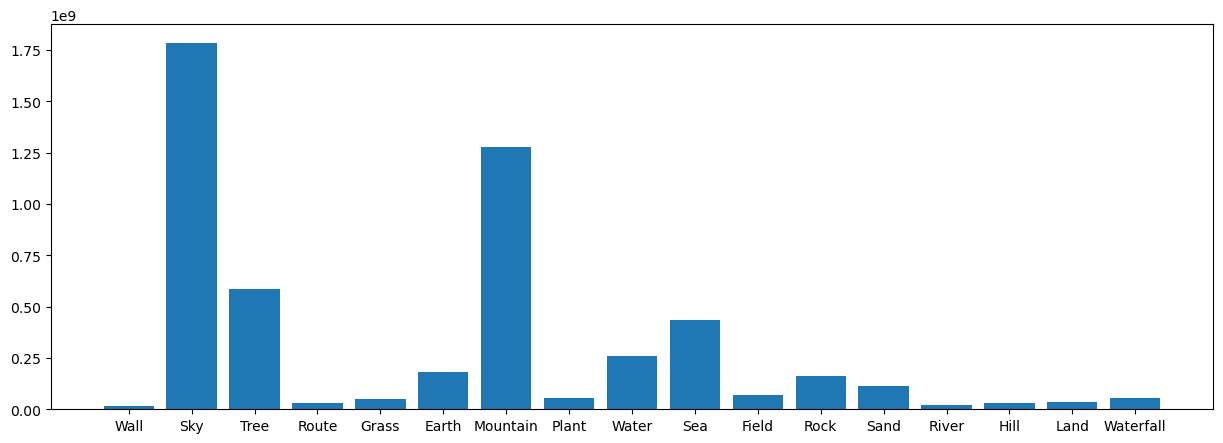

In [10]:
import numpy as np
import matplotlib.pyplot as plt

masks = np.load("masks.npy", mmap_mode="r")
classes = np.unique(masks, return_counts=True)

plt.figure(figsize=(15, 5))
plt.bar(classes[0], classes[1])
plt.xticks(classes[0], [class_names[i]["name"] for i in classes[0]])
plt.show()


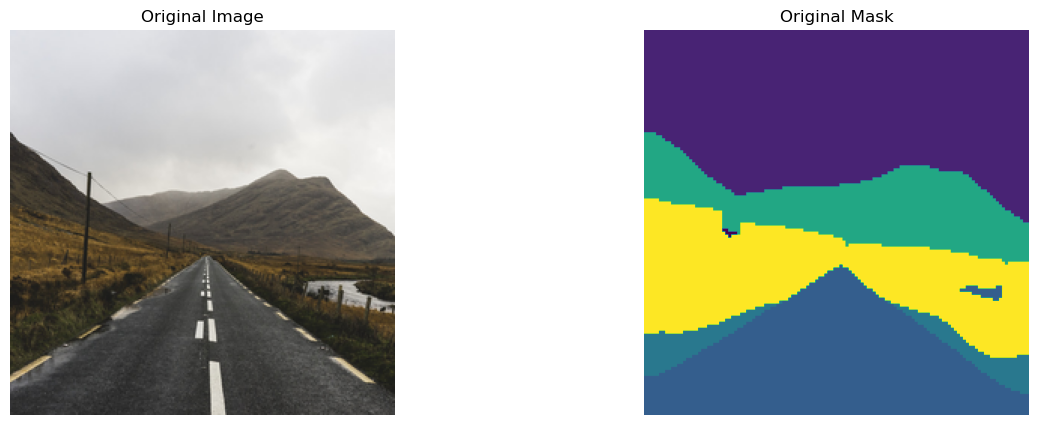

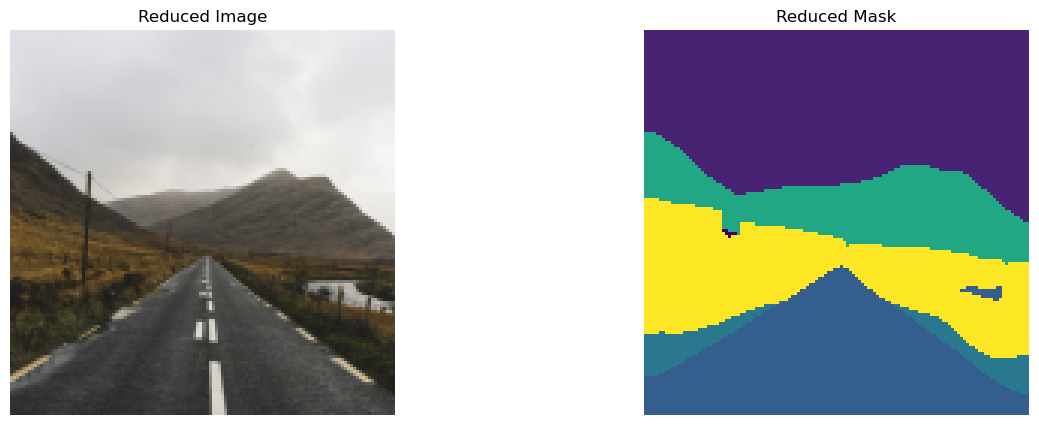

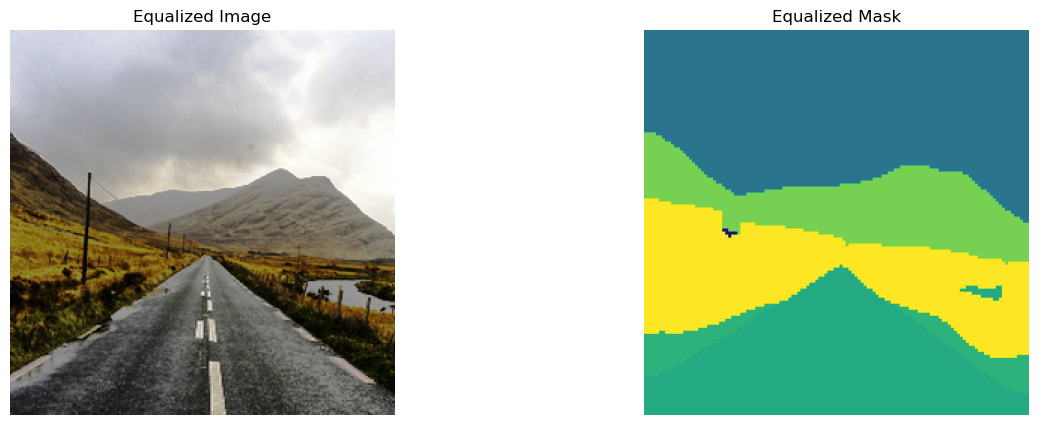

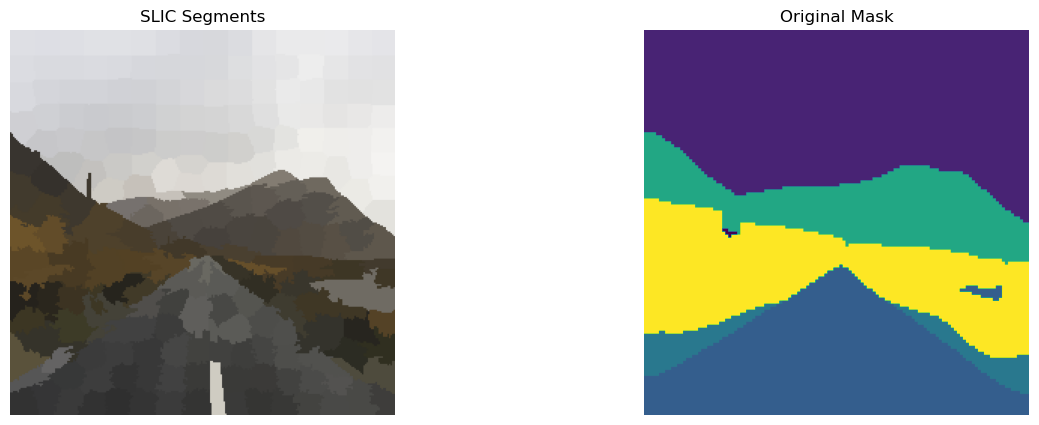

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure, segmentation, color
from skimage.segmentation import slic
from skimage.util import img_as_float
from skimage.transform import resize

# Wczytanie danych
images, masks = (
    np.load("images.npy", mmap_mode="r"),
    np.load("masks.npy", mmap_mode="r"),
)

# Funkcja do wyświetlenia obrazów
def show_images(images, titles, cols=2):
    rows = (len(images) + cols - 1) // cols
    plt.figure(figsize=(15, rows * 5))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, cmap="gray" if len(img.shape) == 2 else None)
        plt.title(title)
        plt.axis("off")
    plt.show()

# Wyświetlenie oryginałów
original_image = images[300]
original_mask = masks[300]
show_images(
    [original_image, original_mask],
    ["Original Image", "Original Mask"],
)

# Zmniejszenie rozdzielczości
reduced_image = resize(original_image, (original_image.shape[0] // 2, original_image.shape[1] // 2), anti_aliasing=True)
reduced_mask = resize(original_mask, (original_mask.shape[0] // 2, original_mask.shape[1] // 2), anti_aliasing=False)
show_images(
    [reduced_image, reduced_mask],
    ["Reduced Image", "Reduced Mask"],
)

# Wyrównanie histogramu
equalized_image = exposure.equalize_hist(original_image)
equalized_mask = exposure.equalize_hist(original_mask)
show_images(
    [equalized_image, equalized_mask],
    ["Equalized Image", "Equalized Mask"],
)

# Segmentacja SLIC
slic_segments = slic(img_as_float(original_image), n_segments=250, compactness=10, start_label=1)
slic_image = color.label2rgb(slic_segments, original_image, kind="avg", bg_label=0)
show_images(
    [slic_image, original_mask],
    ["SLIC Segments", "Original Mask"],
)


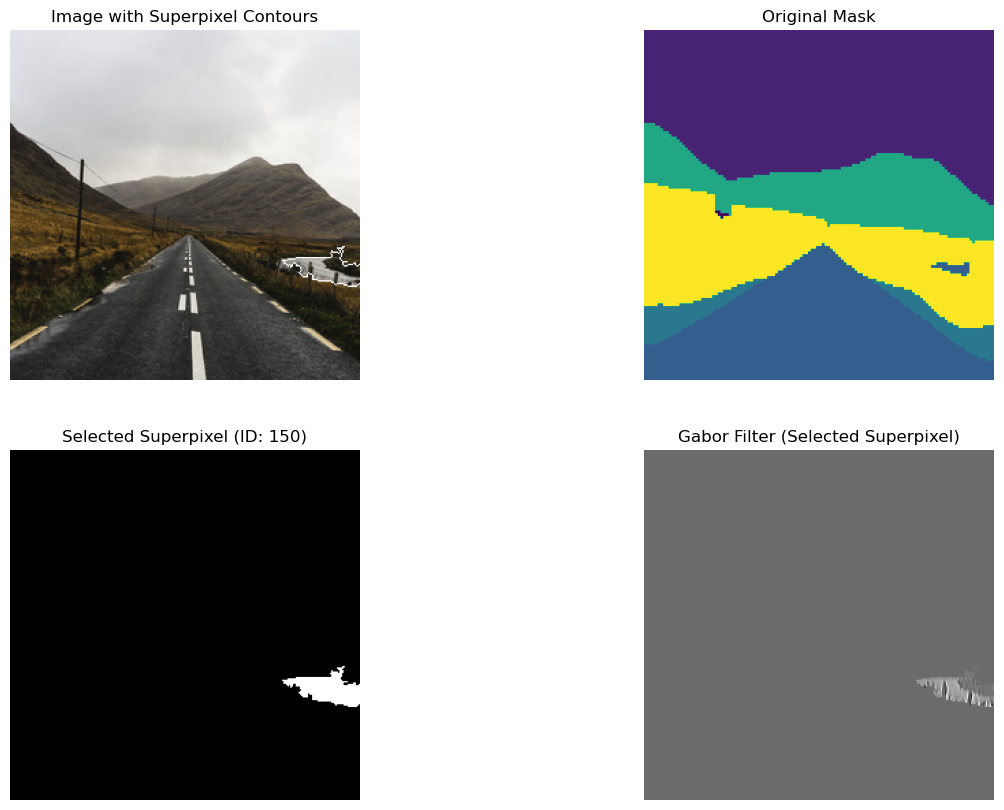

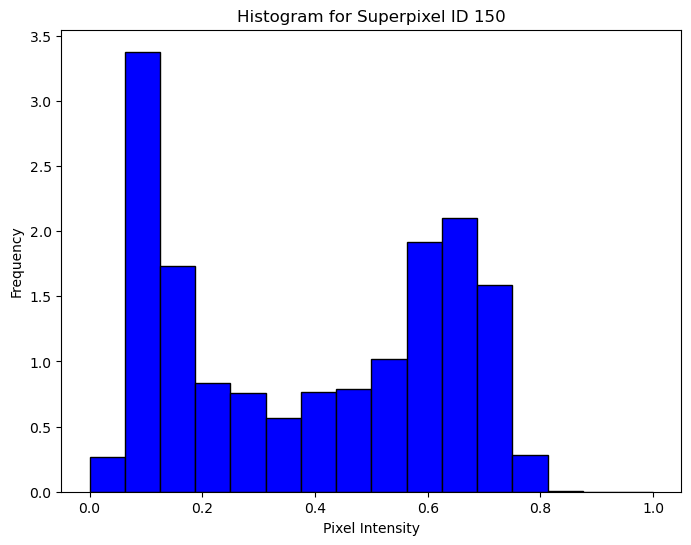

In [61]:
from skimage.filters import gabor
from skimage.color import rgb2gray
from skimage.segmentation import find_boundaries

# Analiza superpikseli z dodatkową diagnostyką
def analyze_superpixels(image, slic_segments):
    unique_segments = np.unique(slic_segments)
    feature_vectors = []

    for segment_id in unique_segments:
        mask = slic_segments == segment_id
        segment_pixels = image[mask]

        # Sprawdzenie, czy superpiksel ma dane
        if segment_pixels.size == 0:
            continue

        # Histogram
        histogram, _ = np.histogram(segment_pixels, bins=16, range=(0, 1), density=True)

        # Filtry Gabora (kierunek 0 i częstotliwość 0.6)
        gabor_real, _ = gabor(rgb2gray(image), frequency=0.6)
        gabor_mean = gabor_real[mask].mean()

        # Tworzenie wektora cech
        feature_vector = np.concatenate([histogram, [gabor_mean]])
        feature_vectors.append(feature_vector)

    return np.array(feature_vectors), unique_segments

# Wybranie superpiksela z większą liczbą pikseli (jeśli segmenty są małe)
segment_sizes = [(slic_segments == seg_id).sum() for seg_id in np.unique(slic_segments)]
selected_segment_id = np.unique(slic_segments)[np.argmax(segment_sizes)]  # Największy segment
selected_mask = slic_segments == selected_segment_id
selected_pixels = normalized_image[selected_mask]

# Histogram wybranego superpiksela
histogram, bins = np.histogram(selected_pixels, bins=16, range=(0, 1), density=True)

# Filtry Gabora dla wybranego superpiksela
gabor_real, _ = gabor(rgb2gray(normalized_image), frequency=0.6)
gabor_segment = gabor_real * selected_mask

# Wyświetlenie konturów superpiksela na obrazie
boundaries = find_boundaries(slic_segments == selected_segment_id, mode="inner")
highlighted_image = normalized_image.copy()
highlighted_image[boundaries] = 1  # Podświetlenie konturów na biało

# Wizualizacja wyników
show_images(
    [
        highlighted_image,
        original_mask,
        selected_mask.astype(float),
        gabor_segment,
    ],
    [
        "Image with Superpixel Contours",
        "Original Mask",
        f"Selected Superpixel (ID: {selected_segment_id})",
        "Gabor Filter (Selected Superpixel)",
    ],
)

# Histogram superpiksela
plt.figure(figsize=(8, 6))
plt.bar(bins[:-1], histogram, width=np.diff(bins), edgecolor="black", align="edge", color="blue")
plt.title(f"Histogram for Superpixel ID {selected_segment_id}")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()


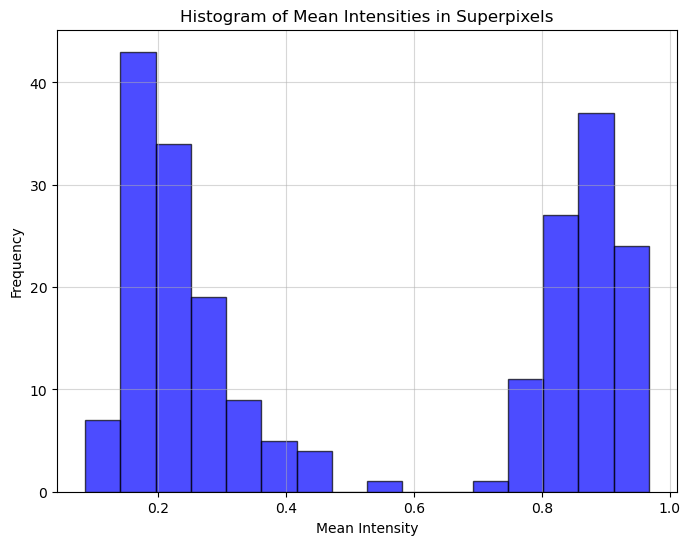

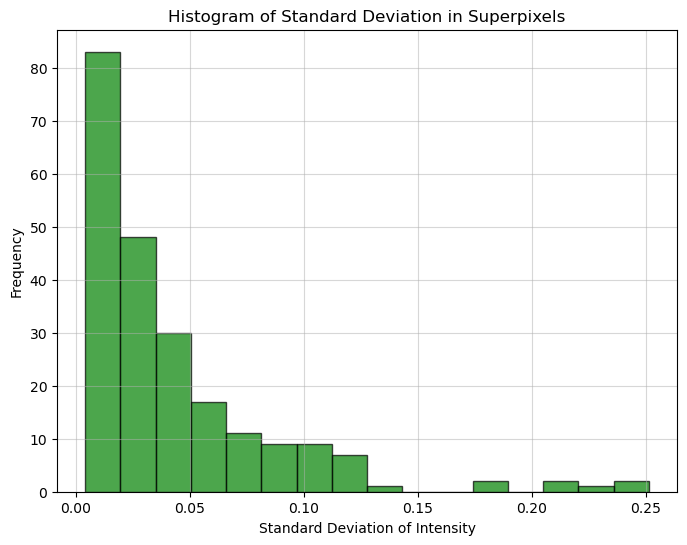

In [63]:
# Histogramy średnich i odchylenia standardowego w superpikselach
def compute_mean_sd_histogram(image, slic_segments):
    unique_segments = np.unique(slic_segments)
    mean_values = []
    sd_values = []

    # Iteracja przez superpiksele
    for segment_id in unique_segments:
        mask = slic_segments == segment_id
        segment_pixels = image[mask]

        if segment_pixels.size > 0:
            mean_values.append(segment_pixels.mean())  # Średnia
            sd_values.append(segment_pixels.std())  # Odchylenie standardowe

    return np.array(mean_values), np.array(sd_values)

# Obliczanie średnich i odchyleń standardowych
mean_values, sd_values = compute_mean_sd_histogram(normalized_image, slic_segments)

# Histogram średnich
plt.figure(figsize=(8, 6))
plt.hist(mean_values, bins=16, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histogram of Mean Intensities in Superpixels")
plt.xlabel("Mean Intensity")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.5)
plt.show()

# Histogram odchylenia standardowego
plt.figure(figsize=(8, 6))
plt.hist(sd_values, bins=16, color="green", edgecolor="black", alpha=0.7)
plt.title("Histogram of Standard Deviation in Superpixels")
plt.xlabel("Standard Deviation of Intensity")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.5)
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


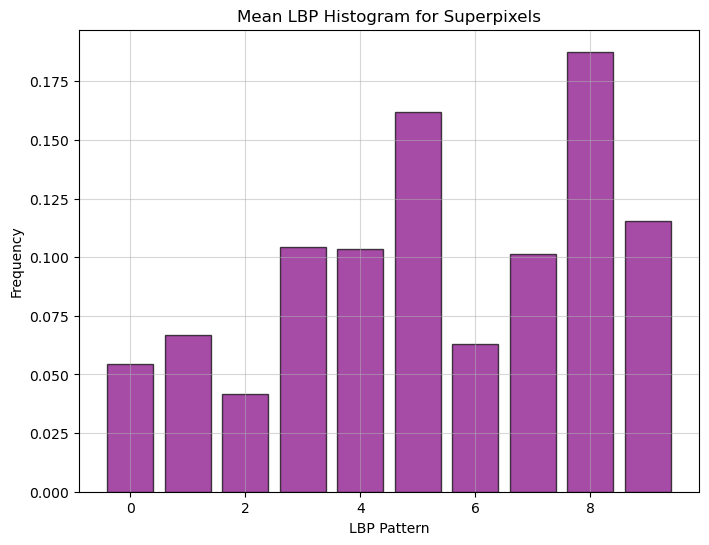

In [64]:
from skimage.feature import local_binary_pattern

# Parametry LBP
radius = 1  # Promień sąsiedztwa
n_points = 8 * radius  # Liczba punktów w sąsiedztwie
method = "uniform"  # Metoda obliczania LBP

# Obliczenie LBP dla całego obrazu
lbp_image = local_binary_pattern(rgb2gray(normalized_image), n_points, radius, method)

# Histogram LBP dla superpikseli
def compute_lbp_histogram(lbp_image, slic_segments):
    unique_segments = np.unique(slic_segments)
    lbp_histograms = []

    for segment_id in unique_segments:
        mask = slic_segments == segment_id
        lbp_values = lbp_image[mask].astype(int)  # LBP dla superpiksela

        # Histogram LBP
        hist, _ = np.histogram(
            lbp_values, bins=np.arange(0, n_points + 3), range=(0, n_points + 2), density=True
        )
        lbp_histograms.append(hist)

    return np.array(lbp_histograms)

# Obliczenie histogramów LBP
lbp_histograms = compute_lbp_histogram(lbp_image, slic_segments)

# Średni histogram LBP dla całego obrazu
mean_lbp_histogram = lbp_histograms.mean(axis=0)

# Wizualizacja średniego histogramu LBP
plt.figure(figsize=(8, 6))
plt.bar(range(len(mean_lbp_histogram)), mean_lbp_histogram, color="purple", edgecolor="black", alpha=0.7)
plt.title("Mean LBP Histogram for Superpixels")
plt.xlabel("LBP Pattern")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.5)
plt.show()


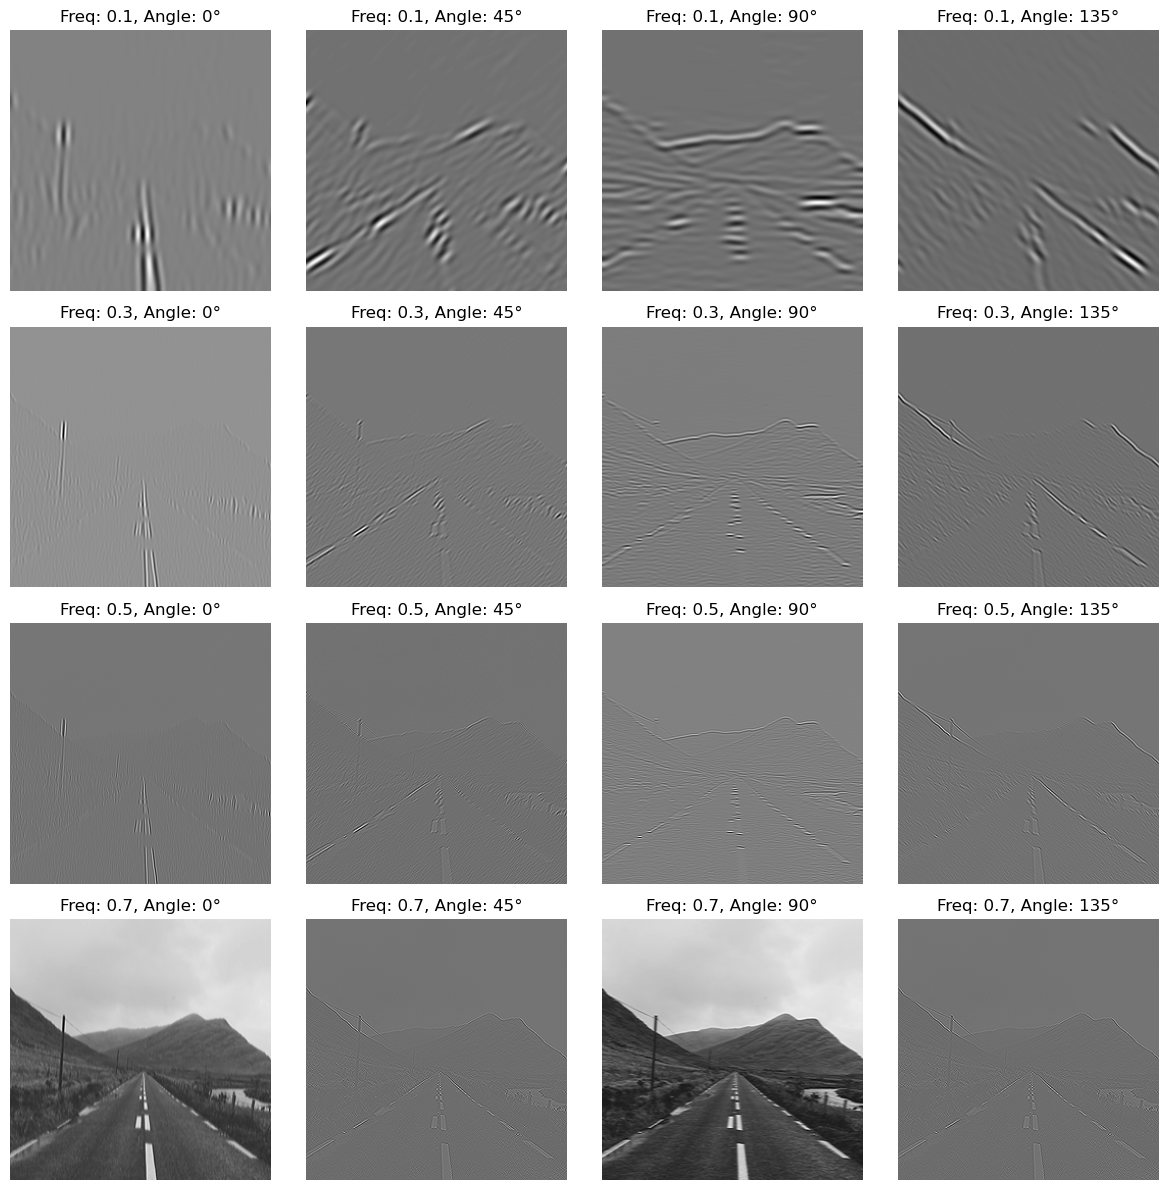

In [65]:
from skimage.filters import gabor
from skimage.color import rgb2gray

# Parametry filtrów Gabora
frequencies = [0.1, 0.3, 0.5, 0.7]  # Różne częstotliwości
angles = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]  # Różne orientacje (kąty)

# Funkcja stosująca filtry Gabora na obrazie
def apply_gabor_filters(image, frequencies, angles):
    gabor_results = []
    
    # Dla każdej częstotliwości i orientacji
    for frequency in frequencies:
        for angle in angles:
            # Zastosowanie filtru Gabora
            real, _ = gabor(rgb2gray(image), frequency=frequency, theta=angle)
            gabor_results.append(real)
    
    return gabor_results

# Zastosowanie filtrów Gabora na znormalizowanym obrazie
gabor_images = apply_gabor_filters(normalized_image, frequencies, angles)

# Wizualizacja wyników filtrów Gabora
fig, axes = plt.subplots(len(frequencies), len(angles), figsize=(12, 12))

for i, frequency in enumerate(frequencies):
    for j, angle in enumerate(angles):
        ax = axes[i, j]
        ax.imshow(gabor_images[i * len(angles) + j], cmap='gray')
        ax.set_title(f'Freq: {frequency}, Angle: {angle * 180 / np.pi:.0f}°')
        ax.axis('off')

plt.tight_layout()
plt.show()


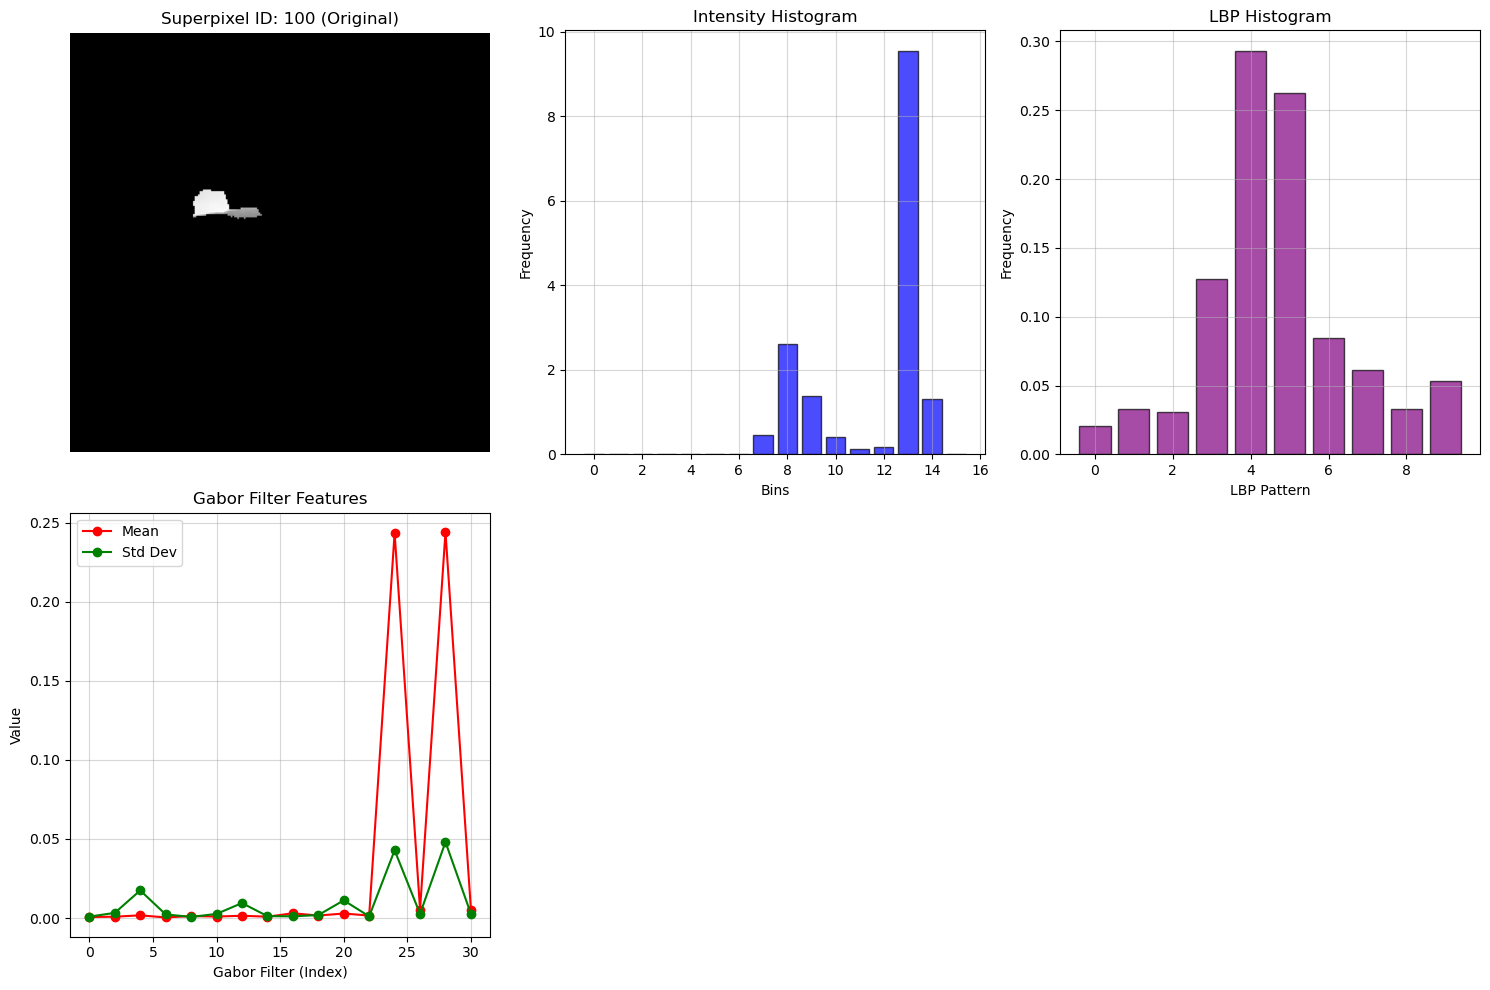

In [70]:
# Funkcja do wizualizacji wybranych cech dla superpikseli
def visualize_superpixel_features(image, slic_segments, feature_vectors, superpixel_id):
    mask = slic_segments == superpixel_id

    # Oryginalny obraz superpiksela
    superpixel_image = np.zeros_like(image)
    superpixel_image[mask] = image[mask]

    # Histogram intensywności
    intensity_hist = feature_vectors[superpixel_id][:16]

    # Histogram LBP
    lbp_hist = feature_vectors[superpixel_id][16:26]

    # Cechy Gabora
    gabor_features = feature_vectors[superpixel_id][26:]

    # Wizualizacja
    plt.figure(figsize=(15, 10))

    # Oryginalny superpiksel
    plt.subplot(2, 3, 1)
    plt.imshow(superpixel_image, cmap="gray")
    plt.title(f"Superpixel ID: {superpixel_id} (Original)")
    plt.axis("off")

    # Histogram intensywności
    plt.subplot(2, 3, 2)
    plt.bar(range(len(intensity_hist)), intensity_hist, color="blue", edgecolor="black", alpha=0.7)
    plt.title("Intensity Histogram")
    plt.xlabel("Bins")
    plt.ylabel("Frequency")
    plt.grid(True, alpha=0.5)

    # Histogram LBP
    plt.subplot(2, 3, 3)
    plt.bar(range(len(lbp_hist)), lbp_hist, color="purple", edgecolor="black", alpha=0.7)
    plt.title("LBP Histogram")
    plt.xlabel("LBP Pattern")
    plt.ylabel("Frequency")
    plt.grid(True, alpha=0.5)

    # Cechy Gabora
    plt.subplot(2, 3, 4)
    plt.plot(range(0, len(gabor_features), 2), gabor_features[0::2], 'r-o', label="Mean")
    plt.plot(range(0, len(gabor_features), 2), gabor_features[1::2], 'g-o', label="Std Dev")
    plt.title("Gabor Filter Features")
    plt.xlabel("Gabor Filter (Index)")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True, alpha=0.5)

    plt.tight_layout()
    plt.show()


# Wizualizacja dla przykładowego superpiksela o ID=1
visualize_superpixel_features(rgb2gray(normalized_image), slic_segments, feature_vectors, superpixel_id=100)


In [72]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Przygotowanie etykiet klas na podstawie maski
def assign_labels(slic_segments, mask):
    unique_segments = np.unique(slic_segments)
    labels = {}

    for segment_id in unique_segments:
        segment_mask = slic_segments == segment_id
        label = np.bincount(mask[segment_mask].flatten()).argmax()  # Najczęstsza klasa w superpikselu
        labels[segment_id] = label

    return labels

# Przygotowanie danych wejściowych
labels = assign_labels(slic_segments, masks[0])  # Przyjmujemy maskę obrazu 0
X = []
y = []

for segment_id, feature_vector in feature_vectors.items():
    X.append(feature_vector)
    y.append(labels[segment_id])

X = np.array(X)
y = np.array(y)

In [75]:
# Podział na zestawy treningowy i testowy (80% trening, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Trenowanie SVM
svm_model = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
svm_model.fit(X_train, y_train)


SVC(C=1, random_state=42)

In [76]:
# Trenowanie Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Ocena modeli
svm_predictions = svm_model.predict(X_test)
rf_predictions = rf_model.predict(X_test)

In [77]:
print("SVM Classification Report:")
print(classification_report(y_test, svm_predictions))
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_predictions))

# Dokładność
print("SVM Accuracy:", accuracy_score(y_test, svm_predictions))
print("Random Forest Accuracy:", accuracy_score(y_test, rf_predictions))

SVM Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           6       0.86      0.97      0.92        39

    accuracy                           0.84        45
   macro avg       0.43      0.49      0.46        45
weighted avg       0.75      0.84      0.79        45

Random Forest Classification Report:
              precision    recall  f1-score   support

           1       0.50      0.67      0.57         6
           6       0.95      0.90      0.92        39

    accuracy                           0.87        45
   macro avg       0.72      0.78      0.75        45
weighted avg       0.89      0.87      0.87        45

SVM Accuracy: 0.8444444444444444
Random Forest Accuracy: 0.8666666666666667


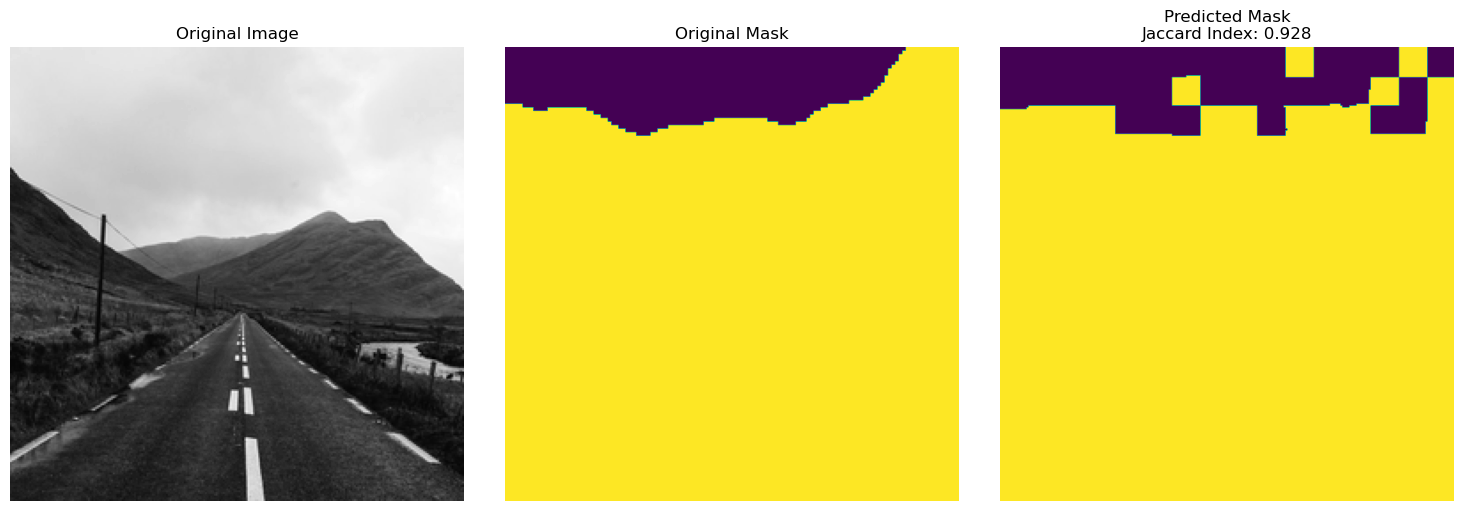

In [78]:
from sklearn.metrics import jaccard_score

# Funkcja do tworzenia maski predykcji na podstawie wyników modelu
def create_predicted_mask(slic_segments, predictions):
    predicted_mask = np.zeros_like(slic_segments)
    for segment_id in np.unique(slic_segments):
        predicted_mask[slic_segments == segment_id] = predictions[segment_id]
    return predicted_mask

# Predykcje dla wszystkich superpikseli
superpixel_predictions = {}
for segment_id in np.unique(slic_segments):
    feature_vector = feature_vectors[segment_id].reshape(1, -1)  # Wektor cech jako wejście
    superpixel_predictions[segment_id] = rf_model.predict(feature_vector)[0]  # Random Forest

# Generowanie maski predykcji
predicted_mask = create_predicted_mask(slic_segments, superpixel_predictions)

# Indeks Jaccard
jaccard_index = jaccard_score(masks[0].flatten(), predicted_mask.flatten(), average='weighted')

# Wizualizacja wyników
plt.figure(figsize=(15, 5))

# Oryginalny obraz
plt.subplot(1, 3, 1)
plt.imshow(rgb2gray(normalized_image), cmap='gray')
plt.title("Original Image")
plt.axis("off")

# Oryginalna maska
plt.subplot(1, 3, 2)
plt.imshow(masks[0], cmap='viridis')
plt.title("Original Mask")
plt.axis("off")

# Predykowana maska
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap='viridis')
plt.title(f"Predicted Mask\nJaccard Index: {jaccard_index:.3f}")
plt.axis("off")

plt.tight_layout()
plt.show()
